In [2]:
# import neccessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# show plot intermediately under the calling cell
%matplotlib inline

# disable some warnings
import warnings
warnings.simplefilter(action = "ignore")

# set to unlimited column display:
pd.set_option('display.max_columns', None)

# import database
df = pd.read_csv('results-2014.csv')

<center>Table: (sample) Dataframe including column dtype</center>

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.3,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
dtypes,object,object,int64,object,object,int64,float64,object,int64,object,object,int64,float64,object,object,object,object,object,object,object,object


# 1. Data cleaning

We convert Gender to number using label encoder with Female is 0 and Male is 1.

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.gender = le.fit_transform(df.gender)

# show label and encoded values
for i, classes in enumerate(le.classes_):
    print("Label:",classes + ", Encoded value:",i )

Label: F, Encoded value: 0
Label: M, Encoded value: 1


We drop rows where distance is not numeric-convertable then  apply the convertion and delete categorical columns.

In [4]:
# drop rows where distance is '-'
df.drop(df[df['10k']=='-'].index, axis=0, inplace=True)
df.drop(df[df['25k']=='-'].index, axis=0, inplace=True)
df.drop(df[df['35k']=='-'].index, axis=0, inplace=True)
df.drop(df[df['30k']=='-'].index, axis=0, inplace=True)
df.drop(df[df['half']=='-'].index, axis=0, inplace=True)
df.drop(df[df['20k']=='-'].index, axis=0, inplace=True)
df.drop(df[df['40k']=='-'].index, axis=0, inplace=True)
df.drop(df[df['5k']=='-'].index, axis=0, inplace=True)

# Convert to numeric
df['10k']=pd.to_numeric(df['10k'])
df['25k']=pd.to_numeric(df['25k'])
df['35k']=pd.to_numeric(df['35k'])
df['30k']=pd.to_numeric(df['30k'])
df['half']=pd.to_numeric(df['half'])
df['20k']=pd.to_numeric(df['20k'])
df['40k']=pd.to_numeric(df['40k'])
df['5k']=pd.to_numeric(df['5k'])

# delete categorical data:
for col in df.columns:
    if df[col].dtype == np.object:
        del df[col]
        
# rearrange column order
df=df[['gender','age','division','genderdiv','overall','pace','5k','10k','20k','half','25k','30k','35k','40k','official']]

<center>Table: Processed database

,division,age,gender,genderdiv,overall,pace,5k,10k,20k,half,25k,30k,35k,40k,official
0,8,47,1,8,8,3.27,8.02,17.37,37.65,39.72,47.67,59.18,71.4,80.43,85.25
1,1,33,0,1,21,5.3,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.1,138.95
dtypes,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


# 2. Descriptive Statistics

We plot the line of all the milestones with the average speed from candidates.

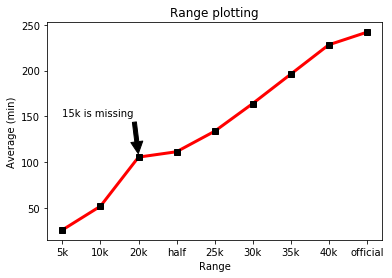

The line can't visualize the speed correctly (the more steep the line is, the faster the average speed of candidates reach) as the milestones are not equally spaced. So we will directly calculate and plot the speed of them.

,5k,10k,20k,25k,30k,35k,40k
cummulative speed,3.245287,3.228157,3.164915,3.119202,3.050736,2.975684,2.921542
range speed,3.245287,3.211207,3.104104,2.948832,2.749031,2.592945,2.591483


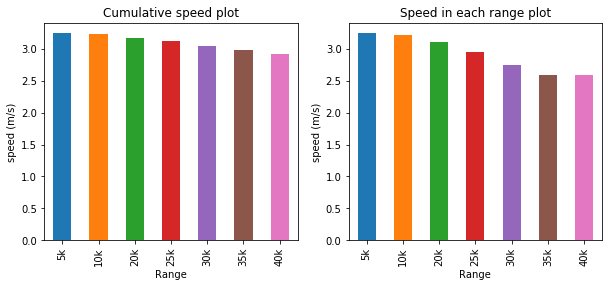

The right plot explains the speed in each range more precisely. It not only shows how the speed decrease but also the stability of speed in the last 10km to the finish line.

<center>Figure: Correlation Matrix of some columns</center>

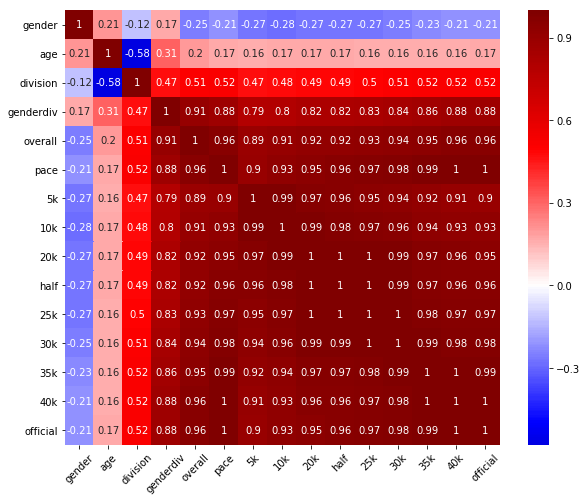

Relationship of 40k, age, genderdiv => not having special pattern to analyze

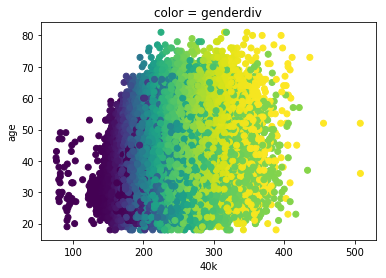

To check 40k and genderdiv relalationship, we use hexagon density plot like below, the darker means that area place more values of 40k-genderdiv pair

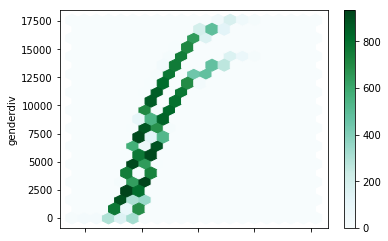

Now we use normal black plot to show the pattern and then check if this pattern has any relationship with gender:

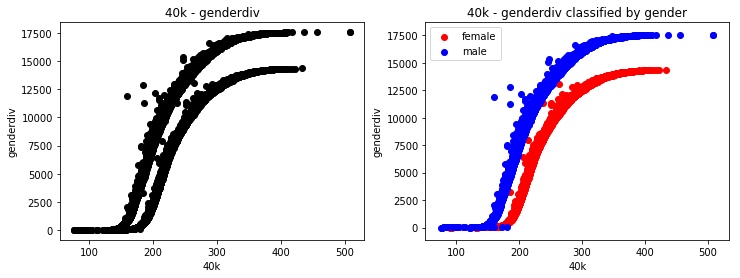

The plot shows there is a obvious relationship between 40k, gender and genderdiv.
Now we start to use Kmean model to see if it can split the data into 2 group as well as above

# 3. Clustering

In [6]:
X = df[['40k','genderdiv']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=['40k','genderdiv'])

In [7]:
# prepare X to cluster
X.head(5)

,40k,genderdiv
0,-3.073612,-1.689122
1,-1.998804,-1.690601
2,-3.163682,-1.690601
3,-1.981123,-1.690179
4,-3.150785,-1.690390


In [6]:
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=8, #int
                tol=0.0001, #float
                n_init=10) #int
# y_pred = kmean.fit_predict(X)

In [7]:
from sklearn.model_selection import RandomizedSearchCV

# Create a parameter grid: map the parameter names to the
# values that should be searched:
param_grid = dict(
    n_clusters=[2],
    tol=np.linspace(0.0001,100,10),
    n_init=[10,100,250,1000],
    algorithm=['auto','full','elkan'],
)

from sklearn.metrics import silhouette_score

# Instantiate the grid:
grid = RandomizedSearchCV(kmean, param_grid, cv=5, error_score=0.0,
                          scoring=silhouette, n_jobs=1, n_iter=10)

# fit the grid with data
grid.fit(X)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

# gre = Gridsearchcv REsult
gre = pd.DataFrame(grid.cv_results_)
(gre.loc[gre.mean_test_score!=0] # skip zero scored rows
     [['rank_test_score','mean_fit_time','mean_test_score'] # get these col
          +['param_{}'.format(i) for i in grid.best_params_.keys()]]
    .sort_values('rank_test_score')) # sort by rank

0.5907653309521744
{'tol': 33.333400000000005, 'n_init': 10, 'n_clusters': 2, 'algorithm': 'elkan'}


,rank_test_score,mean_fit_time,mean_test_score,param_tol,param_n_init,param_n_clusters,param_algorithm
6,1,4.723802,0.590765,33.3334,10,2,elkan
5,2,7.565168,0.590597,55.5556,250,2,full
0,3,7.356740,0.590582,0.0001,100,2,auto
9,4,7.480841,0.590569,100,250,2,full
8,5,9.224999,0.590561,55.5556,1000,2,full
7,6,13.948028,0.590559,0.0001,1000,2,full
4,7,9.200498,0.590553,88.8889,1000,2,full
3,8,7.362303,0.590527,88.8889,250,2,elkan
2,9,7.156601,0.590511,77.7778,100,2,auto
1,10,4.745008,0.590396,11.1112,10,2,full


We chose n_clusters = 2 as the desire that the model can correctly separate the data into 2 groups of male and female like we did manually.
The Parameter changes does not highly effect the mean_test_score (which is silhouette score). But we still apply the best shown model to see how it defines 2 clusters.

In [8]:
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=2,
                tol= 33.3334,
                n_init=10,
                algorithm='elkan',
                n_jobs=16)
y_pred = kmean.fit_predict(X)

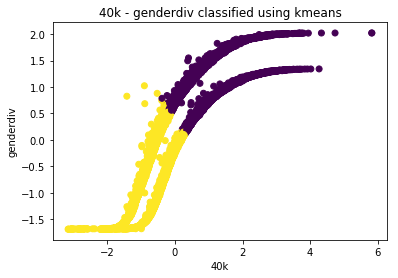

The model is based on distances between points. In this case the shape is too special that it should have been splited by a line between 2 curves. 
Those 2 curves have a small space between which declines when the genderdiv or 40k is smaller and finally merge into a tail. This means models to cluster based on distances between nearest points will impossibly separate this database.
Let's visualize this using DBSCAN:

In [10]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.1, #float
                min_samples=5, #int
                metric='euclidean', # 'cosine','manhattan',
                algorithm='auto') # 'ball_tree','kd_tree','brute'
y_pred = dbscan.fit_predict(X)

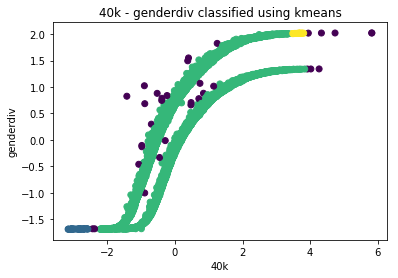

# 4. Conclusion
Several types of clustering does not works well in this case. The best possible type might be Spectral Clustering, but it consumes too much time to learn the model.